<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/Feature_selection_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code is adopted from:

https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/




In [73]:
import numpy as np
import pylab as pl
from sklearn import svm, datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
RAND=123

# import some data to play with
iris = datasets.load_iris()
X = iris.data
#X = scaler.fit_transform(X)
Y = iris.target

X=np.hstack((X,X,10*np.random.random((Y.shape[0], 3))))
X[:,6]=X[:,6]*X[:,0] +5*np.random.random((Y.shape[0]))
X[0:1,:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=RAND)


Let's find a baseline classifier accuracy.

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
nb_model = KNeighborsClassifier(n_neighbors=3, p=1)
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
scores_base=accuracy_score(y_test,y_pred)
print("Baseline accuracy = ", scores_base)

Baseline accuracy =  0.868421052631579


Information Gain:

Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

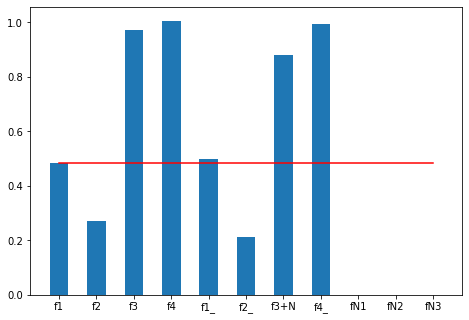

In [75]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
name= ['f1', 'f2', 'f3', 'f4', 'f1_', 'f2_', 'f3+N', 'f4_', 'fN1', 'fN2', 'fN3']
importance = mutual_info_classif(X_train,y_train)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar( name, importance,width=0.5)

th=np.median(importance)
ax.plot(name, th*np.ones((11)), 'r')
plt.show()


**Chi-square Test**

The Chi-square test is used for categorical features in a dataset. We calculate Chi-square between each feature and the target and select the desired number of features with the best Chi-square scores. In order to correctly apply the chi-squared in order to test the relation between various features in the dataset and the target variable, the following conditions have to be met: the variables have to be categorical, sampled independently and values should have an expected frequency greater than 5.

In [76]:
from sklearn.feature_selection import SelectKBest, chi2

#three features selection by Chi-square
chi2_features = SelectKBest(chi2, k=3)

chi2_features.fit(abs(X_train), y_train)

print(chi2_features.get_support())

X_train_filtered = chi2_features.transform(X_train)  #Apply feature selection and return transformed data
X_test_filtered = chi2_features.transform(X_test)

nb_model.fit(X_train_filtered, y_train)
y_pred = nb_model.predict(X_test_filtered)
scores_chi2_features=accuracy_score(y_test,y_pred)
print("chi2_features accuracy = ", scores_chi2_features, "  is it better than Baseline? ", scores_chi2_features>scores_base)

[False False  True False False False  True  True False False False]
chi2_features accuracy =  0.8947368421052632   is it better than Baseline?  True


In [77]:
"""
Review the features
"""
# zip feature names, ranks, and decisions 
feature_ranks = list(zip(name,      chi2_features.get_support()))

# print the results
for feat in feature_ranks:
    print('Feature: {:<10},  Keep: {}'.format(feat[0], feat[1]))

Feature: f1        ,  Keep: False
Feature: f2        ,  Keep: False
Feature: f3        ,  Keep: True
Feature: f4        ,  Keep: False
Feature: f1_       ,  Keep: False
Feature: f2_       ,  Keep: False
Feature: f3+N      ,  Keep: True
Feature: f4_       ,  Keep: True
Feature: fN1       ,  Keep: False
Feature: fN2       ,  Keep: False
Feature: fN3       ,  Keep: False


**Fisher’s Score**

Fisher score is one of the most widely used supervised feature selection methods. The algorithm which we will use returns the ranks of the variables based on the fisher’s score in descending order. We can then select the variables as per the case.

In [78]:
!pip install skfeature-chappers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


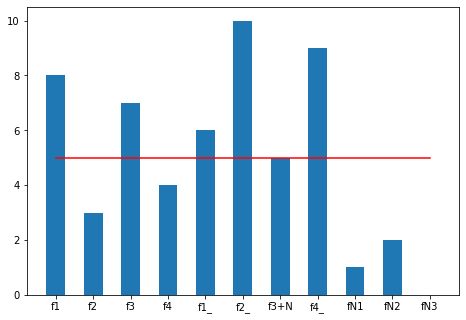

In [79]:
from skfeature.function.similarity_based import fisher_score

ranks = fisher_score.fisher_score(X,Y)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar( name, ranks,width=0.5)

th=np.median(ranks)
ax.plot(name, th*np.ones((11)), 'r')
plt.show()


**Correlation Coefficient**

Correlation is a measure of the linear relationship of 2 or more variables. Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that the good variables are highly correlated with the target. Furthermore, variables should be correlated with the target but should be uncorrelated among themselves.

If two variables are correlated, we can predict one from the other. Therefore, if two features are correlated, the model only really needs one of them, as the second one does not add additional information. We will use the Pearson Correlation here.

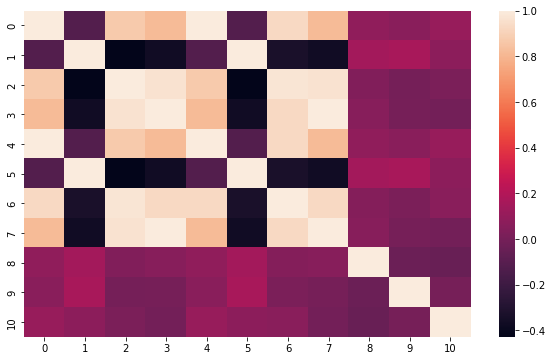

In [80]:
import seaborn as sns

cor = np.corrcoef(X.transpose())
plt.figure(figsize =(10,6))
sns.heatmap(cor)

We need to set an absolute value, say 0.5 as the threshold for selecting the variables. If we find that the predictor variables are correlated among themselves, we can drop the variable which has a lower correlation coefficient value with the target variable. We can also compute multiple correlation coefficients to check whether more than two variables are correlated to each other. This phenomenon is known as multicollinearity.

<Figure size 720x432 with 0 Axes>

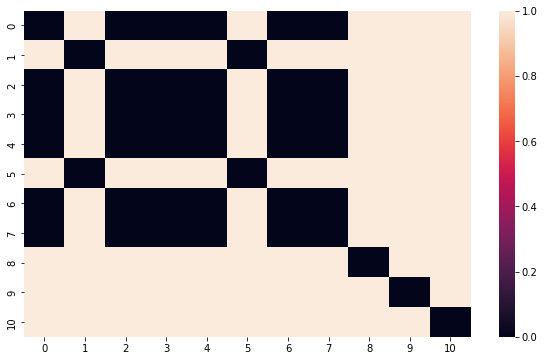

<Figure size 720x432 with 0 Axes>

In [81]:
plt.figure(figsize =(10,6))

sns.heatmap(cor<0.5)

plt.figure(figsize =(10,6))


<BarContainer object of 11 artists>

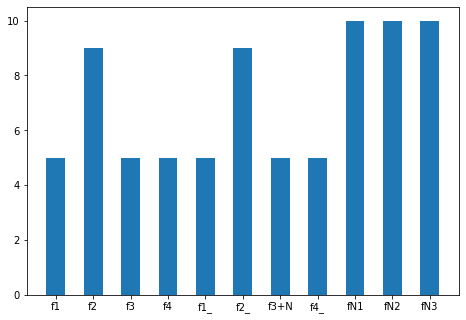

In [82]:

good=sum(cor<0.5)
fig1 = plt.figure()
ax = fig1.add_axes([0,0,1,1])

ax.bar( name, good,width=0.5)

**Variance Threshold**

The variance threshold is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples. We assume that features with a higher variance may contain more useful information, but note that we are not taking the relationship between feature variables or feature and target variables into account, which is one of the drawbacks of filter methods.

In [83]:
from sklearn.feature_selection import VarianceThreshold

v_threshold = VarianceThreshold(threshold=0.0)
v_threshold.fit(X_train)
v_threshold.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

The get_support returns a Boolean vector where True means that the variable does not have zero variance.

**Mean Absolute Difference (MAD)**

‘The mean absolute difference (MAD) computes the absolute difference from the mean value. The main difference between the variance and MAD measures is the absence of the square in the latter. The MAD, like the variance, is also a scale variant.’ [1] This means that higher the MAD, higher the discriminatory power.

<BarContainer object of 11 artists>

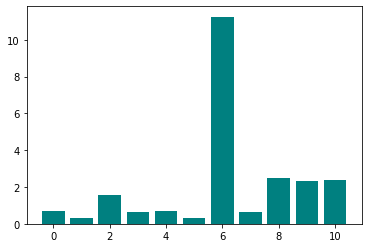

In [84]:
mean_abs_diff = np.sum(np.abs(X-np.mean(X,axis = 0)), axis = 0)/X.shape[0]
plt.bar(np.arange(X.shape[1]), mean_abs_diff, color = 'teal')

**B. Wrapper Methods:**

Wrappers require some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier with that feature subset. The feature selection process is based on a specific machine learning algorithm that we are trying to fit on a given dataset. It follows a greedy search approach by evaluating all the possible combinations of features against the evaluation criterion. The wrapper methods usually result in better predictive accuracy than filter methods.

Let’s, discuss some of these techniques:

**Forward Feature Selection**

This is an iterative method wherein we start with the best performing variable against the target. Next, we select another variable that gives the best performance in combination with the first selected variable. This process continues until the preset criterion is achieved.

In [85]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
sfs = SequentialFeatureSelector(knn, n_features_to_select=4)
sfs.fit(X_train, y_train)

sfs.get_support()
#sfs.transform(X).shape

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False])

In [86]:
X_train_filtered = sfs.transform(X_train)  #Apply feature selection and return transformed data
X_test_filtered = sfs.transform(X_test)

nb_model.fit(X_train_filtered, y_train)
y_pred = nb_model.predict(X_test_filtered)
scores_sfs=accuracy_score(y_test,y_pred)
print("Forward Feature Selection accuracy = ", scores_sfs, ";  Is it better than Baseline? ", scores_sfs>scores_base)

Forward Feature Selection accuracy =  0.9473684210526315 ;  Is it better than Baseline?  True


**Backward Feature Selection**

In [87]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
sfs = SequentialFeatureSelector(knn, direction='backward', n_features_to_select=4)
sfs.fit(X, Y)

sfs.get_support()
#sfs.transform(X).shape

array([False, False,  True, False, False, False,  True, False,  True,
        True, False])

In [92]:
X_train_filtered = sfs.transform(X_train)  #Apply feature selection and return transformed data
X_test_filtered = sfs.transform(X_test)

nb_model.fit(X_train_filtered, y_train)
y_pred = nb_model.predict(X_test_filtered)
scores_bfs=accuracy_score(y_test,y_pred)
print("Backward Feature Selection accuracy = ", scores_bfs, ";  Is it better than Baseline? ", scores_bfs>scores_base)

Backward Feature Selection accuracy =  0.9210526315789473 ;  Is it better than Baseline?  True


In [88]:
"""
Review the features
"""
# zip feature names, ranks, and decisions 
feature_ranks = list(zip(name,      sfs.get_support()))

# print the results
for feat in feature_ranks:
    print('Feature: {:<10},  Keep: {}'.format(feat[0], feat[1]))

Feature: f1        ,  Keep: False
Feature: f2        ,  Keep: False
Feature: f3        ,  Keep: True
Feature: f4        ,  Keep: False
Feature: f1_       ,  Keep: False
Feature: f2_       ,  Keep: False
Feature: f3+N      ,  Keep: True
Feature: f4_       ,  Keep: False
Feature: fN1       ,  Keep: True
Feature: fN2       ,  Keep: True
Feature: fN3       ,  Keep: False


**Exhaustive Feature Selection**

This is the most robust feature selection method covered so far. This is a brute-force evaluation of each feature subset. This means that it tries every possible combination of the variables and returns the best performing subset.
(https://stackoverflow.com/questions/22956938/exhaustively-feature-selection-in-scikit-learn)


In [93]:
from itertools import combinations
from sklearn.model_selection import cross_val_score

def best_subset(estimator, X, y, max_size=8, cv=5):
#Calculates the best model of up to max_size features of X.
#   estimator must have a fit and score functions.
#   X must be a DataFrame.'''

    n_features = X.shape[1]
    subsets = (combinations(range(n_features), k + 1) 
               for k in range(min(n_features, max_size)))

    best_size_subset = []
    for subsets_k in subsets:  # for each list of subsets of the same size
        best_score = -np.inf
        best_subset = None
        for subset in subsets_k: # for each subset
            estimator.fit(X[:, list(subset)], y)
            # get the subset with the best score among subsets of the same size
            score = estimator.score(X[:, list(subset)], y)
            if score > best_score:
                best_score, best_subset = score, subset
        # to compare subsets of different sizes we must use CV
        # first store the best subset of each size
        best_size_subset.append(best_subset)

    # compare best subsets of each size
    best_score = -np.inf
    best_subset = None
    list_scores = []
    for subset in best_size_subset:
        score = cross_val_score(estimator, X[:, list(subset)], y, cv=cv).mean()
        list_scores.append(score)
        if score > best_score:
            best_score, best_subset = score, subset

    return best_subset, best_score, best_size_subset, list_scores


b_subset, b_score, b_size_subset, l_scores=best_subset(knn, X_train, y_train)  
print('b_subset ', b_subset)
print('b_score ',b_score)
print('b_size_subset ', b_size_subset)
print('l_scores ', l_scores)


b_subset  (1, 2, 3)
b_score  0.9727272727272727
b_size_subset  [(3,), (0, 2), (1, 2, 3), (1, 2, 3, 5), (1, 2, 3, 5, 7), (0, 1, 2, 3, 5, 7), (0, 1, 2, 3, 4, 5, 7), (0, 1, 2, 3, 4, 5, 7, 9)]
l_scores  [0.9549407114624506, 0.9545454545454545, 0.9727272727272727, 0.9727272727272727, 0.9727272727272727, 0.9727272727272727, 0.9727272727272727, 0.9280632411067193]


**Recursive Feature Elimination**

‘Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute.

Then, the least important features are pruned from the current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.’(https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [90]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
estimator=DecisionTreeClassifier(max_depth=3)

selector = RFE(estimator, n_features_to_select=4, step=1)
selector = selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)


X_train_filtered = selector.transform(X_train)  #Apply feature selection and return transformed data
X_test_filtered = selector.transform(X_test)

nb_model.fit(X_train_filtered, y_train)
y_pred = nb_model.predict(X_test_filtered)
scores_rfe=accuracy_score(y_test,y_pred)
print("Recursive Feature Elimination accuracy = ", scores_rfe, ";  Is it better than Baseline? ", scores_rfe>scores_base)

[False False  True False False False  True  True False False  True]
[8 7 1 6 5 4 1 1 3 2 1]
Recursive Feature Elimination accuracy =  0.868421052631579 ;  Is it better than Baseline?  False


**C. Embedded Methods:**

These methods encompass the benefits of both the wrapper and filter methods, by including interactions of features but also maintaining reasonable computational cost. Embedded methods are iterative in the sense that takes care of each iteration of the model training process and carefully extracts those features which contribute the most to the training for a particular iteration.

[False False  True  True False False  True  True False False False]


<BarContainer object of 11 artists>

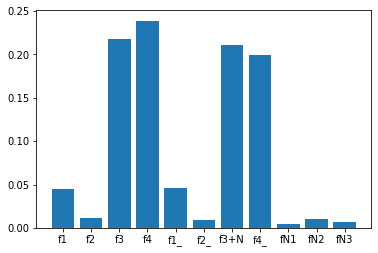

In [95]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

forest =RandomForestClassifier().fit(X_train,y_train)

sfm = SelectFromModel(forest, prefit=True)
#
#
# Here are the important features
#
print(sfm.get_support())

plt.bar(name, forest.feature_importances_)

In [96]:
X_train_filtered = sfm.transform(X_train)  #Apply feature selection and return transformed data
X_test_filtered = sfm.transform(X_test)

nb_model.fit(X_train_filtered, y_train)
y_pred = nb_model.predict(X_test_filtered)
scores_sfm=accuracy_score(y_test,y_pred)
print("Embedded Methods Selection accuracy = ", scores_sfm, ";  Is it better than Baseline? ", scores_sfm>scores_base)

Embedded Methods Selection accuracy =  0.8947368421052632 ;  Is it better than Baseline?  True


Summary

In [99]:
print('Baseline accuracy                      = ', scores_base)
print("chi2_features accuracy                 = ", scores_chi2_features, "  is it better than Baseline? ", scores_chi2_features>scores_base)
print("Forward Feature Selection accuracy     = ", scores_sfs, ";  Is it better than Baseline? ", scores_sfs>scores_base)
print("Backward Feature Selection accuracy    = ", scores_bfs, ";  Is it better than Baseline? ", scores_bfs>scores_base)
print("Recursive Feature Elimination accuracy = ", scores_rfe, ";  Is it better than Baseline? ", scores_rfe>scores_base)
print("Embedded Methods Selection accuracy    = ", scores_sfm, ";  Is it better than Baseline? ", scores_sfm>scores_base)

Baseline accuracy                      =  0.868421052631579
chi2_features accuracy                 =  0.8947368421052632   is it better than Baseline?  True
Forward Feature Selection accuracy     =  0.9473684210526315 ;  Is it better than Baseline?  True
Backward Feature Selection accuracy    =  0.9210526315789473 ;  Is it better than Baseline?  True
Recursive Feature Elimination accuracy =  0.868421052631579 ;  Is it better than Baseline?  False
Embedded Methods Selection accuracy    =  0.8947368421052632 ;  Is it better than Baseline?  True


**Conclusion**

We have discussed a few techniques for feature selection. We have on purpose left the feature extraction techniques like Principal Component Analysis, Singular Value Decomposition, Linear Discriminant Analysis, etc. These methods help to reduce the dimensionality of the data or reduce the number of variables while preserving the variance of the data.

Apart from the methods discussed above, there are many other methods of feature selection. There are hybrid methods too that use both filtering and wrapping techniques. 